These are the pre-photometry steps required to align to Gaia, drizzle together and update the original image DQ extension for CR found during drizzling.

reference notebook:
https://spacetelescope.github.io/notebooks/notebooks/DrizzlePac/align_to_catalogs/align_to_catalogs.html

requirements: astroconda::drizzlepac

In [11]:
# imports
import astropy.units as u
import glob
import numpy as np
import matplotlib.pyplot as plt
import os,shutil

from astropy.io import fits
from astropy.table import Table
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
# from astroquery.mast import Observations
# from astroquery.sdss import SDSS

from ccdproc import ImageFileCollection
from IPython.display import Image

from drizzlepac import tweakreg
from drizzlepac import astrodrizzle

region="off"
filt="f125w"
os.chdir("/Users/remy/cv/magellanic/n159/"+region+"/"+filt+"/")

if filt=="f125w" or filt=="f160w":
    kind="flt"
    camera="IR"
else:
    kind="flc"
    camera="UVO"

In [2]:
collec = ImageFileCollection("./", glob_include="*"+kind+".fits", ext=0,
                             keywords=["targname", "ra_targ", "dec_targ", "filter", "exptime", "postarg1", "postarg2"])

table = collec.summary
table['exptime'].format = '7.1f'
table['ra_targ'].format = '7.7f'
table['dec_targ'].format = '7.7f'
table['postarg1'].format = '7.2f'
table['postarg2'].format = '7.2f'
table

file,targname,ra_targ,dec_targ,filter,exptime,postarg1,postarg2
str18,str9,float64,float64,str5,float64,float64,float64
icbna6jcq_flt.fits,OFF-POINT,85.2508983,-69.8056833,F125W,699.2,5.55,2.47
icbna6jlq_flt.fits,OFF-POINT,85.2508983,-69.8056833,F125W,399.2,5.71,1.94
icbna6joq_flt.fits,OFF-POINT,85.2508983,-69.8056833,F125W,299.2,5.74,3.00


In [ ]:
# Gaia query
RA = table['ra_targ'][0]
Dec = table['dec_targ'][0]

coord = SkyCoord(ra=RA, dec=Dec, unit=(u.deg, u.deg))
radius = Quantity(3., u.arcmin)

gaia_query = Gaia.query_object_async(coordinate=coord, radius=radius)
reduced_query = gaia_query['ra', 'dec', 'phot_g_mean_mag']
reduced_query
reduced_query.write('gaia.cat', format='ascii.commented_header')

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


IR 2.5
Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 11:09:59.098 (08/06/2021) 


TweakReg Version 1.4.7(18-April-2018) started at: 11:09:59.098 (08/06/2021) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [Clang 10.0.0 ]


Python Version [Clang 10.0.0 ]


INFO:drizzlepac.util:3.7.10 (default, Feb 26 2021, 10:16:00) 


3.7.10 (default, Feb 26 2021, 10:16:00) 


INFO:drizzlepac.util:numpy Version -> 1.20.2 


numpy Version -> 1.20.2 


INFO:drizzlepac.util:astropy Version -> 4.2.1 


astropy Version -> 4.2.1 


INFO:drizzlepac.util:stwcs Version -> 1.6.1 


stwcs Version -> 1.6.1 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	input :	*flt.fits
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    icbna6joq_flt.fits


    icbna6joq_flt.fits


INFO:drizzlepac.tweakreg:    icbna6jcq_flt.fits


    icbna6jcq_flt.fits


INFO:drizzlepac.tweakreg:    icbna6jlq_flt.fits


    icbna6jlq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	2.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	*flt.fits
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	sharphi :	1.0
INFO:drizzlepac.tweakreg:	sharplo :	0.2
INFO:drizzlepac.tweakreg:	skysigma :	0.0
INFO:drizzlepac.tweakreg:	th

===  Source finding for image 'icbna6joq_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'icbna6joq_flt.fits', EXT=('SCI', 1) started at: 11:09:59.505 (08/06/2021)


  #  Source finding for 'icbna6joq_flt.fits', EXT=('SCI', 1) started at: 11:09:59.505 (08/06/2021)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.335006
INFO:drizzlepac.catalogs:###Source finding finished at: 11:09:59.667 (08/06/2021)
INFO:drizzlepac.catalogs:     Found 361 objects.


     Found 361 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'icbna6joq_flt.fits': 361


===  FINAL number of objects in image 'icbna6joq_flt.fits': 361


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'icbna6jcq_flt.fits':


===  Source finding for image 'icbna6jcq_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'icbna6jcq_flt.fits', EXT=('SCI', 1) started at: 11:09:59.85 (08/06/2021)


  #  Source finding for 'icbna6jcq_flt.fits', EXT=('SCI', 1) started at: 11:09:59.85 (08/06/2021)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.346202
INFO:drizzlepac.catalogs:###Source finding finished at: 11:09:59.989 (08/06/2021)
INFO:drizzlepac.catalogs:     Found 363 objects.


     Found 363 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'icbna6jcq_flt.fits': 363


===  FINAL number of objects in image 'icbna6jcq_flt.fits': 363


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'icbna6jlq_flt.fits':


===  Source finding for image 'icbna6jlq_flt.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'icbna6jlq_flt.fits', EXT=('SCI', 1) started at: 11:10:00.162 (08/06/2021)


  #  Source finding for 'icbna6jlq_flt.fits', EXT=('SCI', 1) started at: 11:10:00.162 (08/06/2021)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.571396
INFO:drizzlepac.catalogs:###Source finding finished at: 11:10:00.312 (08/06/2021)
INFO:drizzlepac.catalogs:     Found 357 objects.


     Found 357 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'icbna6jlq_flt.fits': 357


===  FINAL number of objects in image 'icbna6jlq_flt.fits': 357


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image (not used):
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	*flt.fits
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	sharphi :	1.0
INFO:drizzlepac.tweakreg:	sharplo :	0.2
INFO:drizzlepac.tweakreg:	sky

INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'icbna6joq_flt.fits'


derived from 'icbna6joq_flt.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	False
INFO:drizzlepac.tweakreg:	separation :	0.5
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	general
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	nclip :	3
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	2.3
INFO:drizzlepac.tweakreg:	ylimit :	0.2
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg:

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: icbna6joq_flt.fits


Performing fit for: icbna6joq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'icbna6joq_flt.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'icbna6joq_flt.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.1593, 0.1593 with significance of 21 and 23 matches


Found initial X and Y shifts of 0.1593, 0.1593 with significance of 21 and 23 matches


INFO:drizzlepac.imgclasses:Found 23 matches for icbna6joq_flt.fits...


Found 23 matches for icbna6joq_flt.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  icbna6joq_flt.fits : 


Computed  general  fit for  icbna6joq_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.1229  YSH: 0.1299    PROPER ROT: 359.9814893    


XSH: 0.1229  YSH: 0.1299    PROPER ROT: 359.9814893    


INFO:drizzlepac.imgclasses:<ROT>: 359.9814893  SKEW: -0.002984235077    ROT_X: 359.9829814  ROT_Y: 359.9799972


<ROT>: 359.9814893  SKEW: -0.002984235077    ROT_X: 359.9829814  ROT_Y: 359.9799972


INFO:drizzlepac.imgclasses:<SCALE>: 1.000037937  SCALE_X: 0.9999418133  SCALE_Y: 1.000134072


<SCALE>: 1.000037937  SCALE_X: 0.9999418133  SCALE_Y: 1.000134072


INFO:drizzlepac.imgclasses:FIT XRMS: 0.054      FIT YRMS: 0.034  


FIT XRMS: 0.054      FIT YRMS: 0.034  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.064      FIT MAE: 0.06   


FIT RMSE: 0.064      FIT MAE: 0.06   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 6.1e-06 (deg)   RMS_DEC: 9e-07 (deg)


RMS_RA: 6.1e-06 (deg)   RMS_DEC: 9e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  22  objects.


Final solution based on  22  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: icbna6joq_flt_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  icbna6joq_flt_catalog_fit.match


wrote XY data to:  icbna6joq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 22


Total # points: 22


INFO:drizzlepac.tweakutils:# of points after clipping: 22


# of points after clipping: 22


INFO:drizzlepac.tweakutils:Total # points: 22


Total # points: 22


INFO:drizzlepac.tweakutils:# of points after clipping: 22


# of points after clipping: 22


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for icbna6joq_flt.fits...


....Updating header for icbna6joq_flt.fits...


INFO:drizzlepac.updatehdr:


        Use archive_wcs instead.
  wcsutil.altwcs.archiveWCS(fimg, extlist, reusekey=True)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing icbna6joq_flt.fits['SCI',1]


Processing icbna6joq_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for icbna6joq_flt.fits[1]


Updating header for icbna6joq_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -2.1471345596449802e-05 -2.764898099288616e-05


CD_11  CD_12: -2.1471345596449802e-05 -2.764898099288616e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -3.088883705229383e-05 1.9082555507788906e-05


CD_21  CD_22: -3.088883705229383e-05 1.9082555507788906e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.26271455573112 -69.80426902302175


CRVAL    : 85.26271455573112 -69.80426902302175


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.13541813968905003


Plate Scale : 0.13541813968905003


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -55.38764448541203


ORIENTAT : -55.38764448541203


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


        Use archive_wcs instead.
  wcskey=wkey, reusekey=reusename)

INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: " "
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "Gaia"
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: icbna6jcq_flt.fits


Performing fit for: icbna6jcq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'icbna6jcq_flt.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'icbna6jcq_flt.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.08273, 0.1627 with significance of 17.75 and 25 matches


Found initial X and Y shifts of 0.08273, 0.1627 with significance of 17.75 and 25 matches


INFO:drizzlepac.imgclasses:Found 25 matches for icbna6jcq_flt.fits...


Found 25 matches for icbna6jcq_flt.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  icbna6jcq_flt.fits : 


Computed  general  fit for  icbna6jcq_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0613  YSH: 0.1406    PROPER ROT: 359.9967342    


XSH: 0.0613  YSH: 0.1406    PROPER ROT: 359.9967342    


INFO:drizzlepac.imgclasses:<ROT>: 179.9967342  SKEW: 359.9772792    ROT_X: 0.008094631884  ROT_Y: 359.9853738


<ROT>: 179.9967342  SKEW: 359.9772792    ROT_X: 0.008094631884  ROT_Y: 359.9853738


INFO:drizzlepac.imgclasses:<SCALE>: 0.9999669957  SCALE_X: 1.000110909  SCALE_Y: 0.9998231821


<SCALE>: 0.9999669957  SCALE_X: 1.000110909  SCALE_Y: 0.9998231821


INFO:drizzlepac.imgclasses:FIT XRMS: 0.044      FIT YRMS: 0.051  


FIT XRMS: 0.044      FIT YRMS: 0.051  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.067      FIT MAE: 0.063  


FIT RMSE: 0.067      FIT MAE: 0.063  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 6.9e-06 (deg)   RMS_DEC: 2.5e-07 (deg)


RMS_RA: 6.9e-06 (deg)   RMS_DEC: 2.5e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  24  objects.


Final solution based on  24  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: icbna6jcq_flt_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  icbna6jcq_flt_catalog_fit.match


wrote XY data to:  icbna6jcq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 24


Total # points: 24


INFO:drizzlepac.tweakutils:# of points after clipping: 24


# of points after clipping: 24


INFO:drizzlepac.tweakutils:Total # points: 24


Total # points: 24


INFO:drizzlepac.tweakutils:# of points after clipping: 24


# of points after clipping: 24


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for icbna6jcq_flt.fits...


....Updating header for icbna6jcq_flt.fits...


INFO:drizzlepac.updatehdr:


        Use archive_wcs instead.
  wcsutil.altwcs.archiveWCS(fimg, extlist, reusekey=True)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing icbna6jcq_flt.fits['SCI',1]


Processing icbna6jcq_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for icbna6jcq_flt.fits[1]


Updating header for icbna6jcq_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -2.1481072412949866e-05 -2.765528037798503e-05


CD_11  CD_12: -2.1481072412949866e-05 -2.765528037798503e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -3.087362900013263e-05 1.9091104752003845e-05


CD_21  CD_22: -3.087362900013263e-05 1.9091104752003845e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.2622428681337 -69.80423262989736


CRVAL    : 85.2622428681337 -69.80423262989736


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.13541620722827333


Plate Scale : 0.13541620722827333


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -55.38174870715067


ORIENTAT : -55.38174870715067


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


        Use archive_wcs instead.
  wcskey=wkey, reusekey=reusename)

INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: " "
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "Gaia"
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: icbna6jlq_flt.fits


Performing fit for: icbna6jlq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'icbna6jlq_flt.fits' with sources from reference catalog 'gaia.cat'


Matching sources from 'icbna6jlq_flt.fits' with sources from reference catalog 'gaia.cat'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.06637, 0.2027 with significance of 13.44 and 22 matches


Found initial X and Y shifts of 0.06637, 0.2027 with significance of 13.44 and 22 matches


INFO:drizzlepac.imgclasses:Found 22 matches for icbna6jlq_flt.fits...


Found 22 matches for icbna6jlq_flt.fits...


INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.linearfit:Performing "general" fit
INFO:drizzlepac.imgclasses:Computed  general  fit for  icbna6jlq_flt.fits : 


Computed  general  fit for  icbna6jlq_flt.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0517  YSH: 0.1151    PROPER ROT: 0.001227804244    


XSH: 0.0517  YSH: 0.1151    PROPER ROT: 0.001227804244    


INFO:drizzlepac.imgclasses:<ROT>: 180.0012278  SKEW: -359.9796366    ROT_X: 359.9910461  ROT_Y: 0.01140949061


<ROT>: 180.0012278  SKEW: -359.9796366    ROT_X: 359.9910461  ROT_Y: 0.01140949061


INFO:drizzlepac.imgclasses:<SCALE>: 0.9998025966  SCALE_X: 0.9998483003  SCALE_Y: 0.9997569581


<SCALE>: 0.9998025966  SCALE_X: 0.9998483003  SCALE_Y: 0.9997569581


INFO:drizzlepac.imgclasses:FIT XRMS: 0.032      FIT YRMS: 0.034  


FIT XRMS: 0.032      FIT YRMS: 0.034  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.047      FIT MAE: 0.042  


FIT RMSE: 0.047      FIT MAE: 0.042  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4.8e-06 (deg)   RMS_DEC: 2.2e-07 (deg)


RMS_RA: 4.8e-06 (deg)   RMS_DEC: 2.2e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  19  objects.


Final solution based on  19  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: icbna6jlq_flt_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  icbna6jlq_flt_catalog_fit.match


wrote XY data to:  icbna6jlq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 19


Total # points: 19


INFO:drizzlepac.tweakutils:# of points after clipping: 19


# of points after clipping: 19


INFO:drizzlepac.tweakutils:Total # points: 19


Total # points: 19


INFO:drizzlepac.tweakutils:# of points after clipping: 19


# of points after clipping: 19


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for icbna6jlq_flt.fits...


....Updating header for icbna6jlq_flt.fits...


INFO:drizzlepac.updatehdr:


        Use archive_wcs instead.
  wcsutil.altwcs.archiveWCS(fimg, extlist, reusekey=True)

INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing icbna6jlq_flt.fits['SCI',1]


Processing icbna6jlq_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for icbna6jlq_flt.fits[1]


Updating header for icbna6jlq_flt.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: -2.1476344950266975e-05 -2.7648170316016058e-05


CD_11  CD_12: -2.1476344950266975e-05 -2.7648170316016058e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: -3.088785952887531e-05 1.9103513172498033e-05


CD_21  CD_22: -3.088785952887531e-05 1.9103513172498033e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.26198570238377 -69.80411136246543


CRVAL    : 85.26198570238377 -69.80411136246543


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 507.0 507.0


CRPIX    : 507.0 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1014 1014


NAXIS    : 1014 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.13541268636932835


Plate Scale : 0.13541268636932835


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : -55.35745207875159


ORIENTAT : -55.35745207875159


INFO:drizzlepac.updatehdr:WCSNAME  :  Gaia


WCSNAME  :  Gaia


        Use archive_wcs instead.
  wcskey=wkey, reusekey=reusename)

INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: " "
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "Gaia"
INFO:drizzlepac.tweakutils:Writing out shiftfile : Gaia_shifts.txt


Writing out shiftfile : Gaia_shifts.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


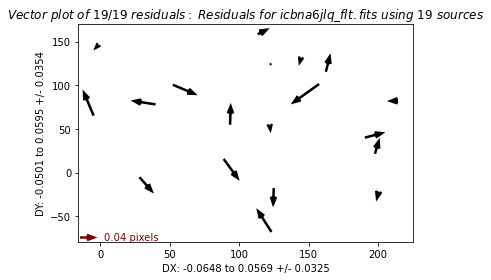

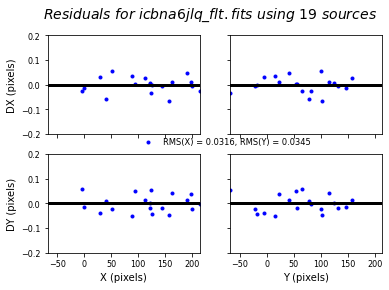

In [4]:
refcat = 'gaia.cat'
if camera=="UVO":
    cw = 3.5  # Set to two times the FWHM of the PSF.
    thresh=1000.
else:
    cw = 2.5
    thresh=100.
wcsname = 'Gaia'  # Specify the WCS name for this alignment
print(camera,cw)

for im in glob.glob("*"+kind+".fits"):
    if not os.path.exists(im[:-5]+".orig.fits"):
        shutil.copy(im,im[:-5]+".orig.fits")
    
tweakreg.TweakReg('*'+kind+'.fits',  # Pass input images
                  updatehdr=True,  # update header with new WCS solution
                  imagefindcfg={'threshold':thresh,'conv_width':cw},  # Detection parameters, threshold varies for different data
                  refcat=refcat,  # Use user supplied catalog (Gaia)
                  interactive=False,
                  see2dplot=False,
                  shiftfile=True,  # Save out shift file (so we can look at shifts later)
                  outshifts='Gaia_shifts.txt',  # name of the shift file
                  wcsname=wcsname,  # Give our WCS a new name
                  reusename=True,
                  sigma=2.3,
                  ylimit=0.2,
                  fitgeometry='general')  # Use the 6 parameter fit



In [5]:
for line in open('Gaia_shifts.txt').readlines():
    print(line)

# frame: output

# refimage: shifts_wcs.fits[wcs]

# form: delta

# units: pixels

icbna6joq_flt.fits    0.122855  0.129949    359.981489     1.000038   0.054251  0.033671

icbna6jcq_flt.fits    0.061349  0.140590    359.996734     0.999967   0.044208  0.050983

icbna6jlq_flt.fits    0.051722  0.115113    0.001228     0.999803   0.031626  0.034451



In [7]:
# we have 4 exposures of ~same etime, so mosaic them all
astrodrizzle.AstroDrizzle('*'+kind+'.fits', 
                          output=filt,
                          preserve=False,
                          clean=True, 
                          build=True,
                          context=False,
                          skymethod='match',
                          driz_sep_bits='64, 32',
                          combine_type='minmed',
                          final_bits='64, 32')

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.1.6 (2020-02-19 16:16:30 -0500) started at: 11:11:02.529 (08/06/2021)


AstroDrizzle Version 3.1.6 (2020-02-19 16:16:30 -0500) started at: 11:11:02.529 (08/06/2021)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version [Clang 10.0.0 ]
INFO:drizzlepac.astrodrizzle:3.7.10 (default, Feb 26 2021, 10:16:00) 
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.20.2 
INFO:drizzlepac.astrodrizzle:astropy Version -> 4.2.1 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.6.1 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  11:11:02.584 (08/06/2021)


==== Processing Step  Initialization  started at  11:11:02.584 (08/06/2021)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: f125w_drz.fits
INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0539170329309902
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.3538148322941206
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.imageObject:No context image will be created for icbna6jcq_flt.fits
INFO:drizzlepac.imageObject:No context image will be created for icbna6jlq_flt.fits
INFO:drizzlepac.imageObject:No context image will be created for icbna6joq_flt.fits
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in icbna6jcq_flt.fits[DQ,1]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in icbna6jlq_flt.fits[DQ,1]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in icbna6joq_flt.fits[DQ,1]
INFO:drizzlepac.processInput:-Creating output WCS.
INFO:drizzlepa

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.26138383791843  -69.8041061414242  


CRVAL : 85.26138383791843  -69.8041061414242  


INFO:astropy.wcs.wcs:CRPIX : 542.5  484.0  


CRPIX : 542.5  484.0  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -2.0428236686885658e-05  -2.9186089623123398e-05  


CD1_1 CD1_2  : -2.0428236686885658e-05  -2.9186089623123398e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -2.9186089623123398e-05  2.0428236686885658e-05  


CD2_1 CD2_2  : -2.9186089623123398e-05  2.0428236686885658e-05  


INFO:astropy.wcs.wcs:NAXIS : 1085  968


NAXIS : 1085  968


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 59 Mb.


*  Estimated memory usage:  up to 59 Mb.


INFO:drizzlepac.processInput:*  Output image size:       1085 X 968 pixels. 


*  Output image size:       1085 X 968 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 12 Mb. 


*  Output image file:       ~ 12 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         3


*  Cores available:         3


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step Initialization finished at 11:11:03.640 (08/06/2021)


==== Processing Step Initialization finished at 11:11:03.640 (08/06/2021)


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	True
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	False
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	*flt.fits
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	f125w
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	4096
INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlepac.astrodrizzle:	wcskey :	
INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  11:11:03.689 (08/06/2021)


==== Processing Step  Static Mask  started at  11:11:03.689 (08/06/2021)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  0.913811;   rms = 0.699706;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  1.219406;   rms = 0.694119;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  0.880837;   rms = 0.710502;   static_sig = 4.00
INFO:drizzlepac.staticMask:Saving static mask to disk: ./WFC3IR_1014x1014_1_staticMask.fits
INFO:drizzlepac.util:==== Processing Step Static Mask finished at 11:11:03.87 (08/06/2021)


==== Processing Step Static Mask finished at 11:11:03.87 (08/06/2021)


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  11:11:03.878 (08/06/2021)


==== Processing Step  Subtract Sky  started at  11:11:03.878 (08/06/2021)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:
INFO:drizzlepac.sky:	sky_bits :	0
INFO:drizzlepac.sky:	skyclip :	5
INFO:drizzlepac.sky:	skyfile :	
INFO:drizzlepac.sky:	skylower :	None
INFO:drizzlepac.sky:	skylsigma :	4.0
INFO:drizzlepac.sky:	skymask_cat :	
INFO:drizzlepac.sky:	skymethod :	match
INFO:drizzlepac.sky:	skystat :	median
INFO:drizzlepac.sky:	skysub :	True
INFO:drizzlepac.sky:	skyupper :	None
INFO:drizzlepac.sky:	skyuser :	
INFO:drizzlepac.sky:	skyusigma :	4.0
INFO:drizzlepac.sky:	skywidth :	0.1
INFO:drizzlepac.sky:	use_static :	True
INFO:stsci.skypac.utils:***** skymatch started on 2021-06-08 11:11:04.031653


***** skymatch started on 2021-06-08 11:11:04.031653


INFO:stsci.skypac.utils:      Version 1.0.5


      Version 1.0.5


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'icbna6jcq_flt.fits'


   **  Input image: 'icbna6jcq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: icbna6jcq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: icbna6jcq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'icbna6jlq_flt.fits'


   **  Input image: 'icbna6jlq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: icbna6jlq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: icbna6jlq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'icbna6joq_flt.fits'


   **  Input image: 'icbna6joq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: icbna6joq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: icbna6joq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: icbna6jcq_flt.fits


   *   Image: icbna6jcq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: icbna6jlq_flt.fits


   *   Image: icbna6jlq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: icbna6joq_flt.fits


   *   Image: icbna6joq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing differences in sky values in overlapping regions:  -----


-----  Computing differences in sky values in overlapping regions:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'icbna6jcq_flt.fits['SCI',1]' SKY = 3.27802 [brightness units]


   *   Image 'icbna6jcq_flt.fits['SCI',1]' SKY = 3.27802 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.053917


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.053917


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'icbna6jlq_flt.fits['SCI',1]' SKY = 21.511 [brightness units]


   *   Image 'icbna6jlq_flt.fits['SCI',1]' SKY = 21.511 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.353815


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.353815


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'icbna6joq_flt.fits['SCI',1]' SKY = 0 [brightness units]


   *   Image 'icbna6joq_flt.fits['SCI',1]' SKY = 0 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:***** skymatch ended on 2021-06-08 11:11:07.185132


***** skymatch ended on 2021-06-08 11:11:07.185132


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:03.153479


TOTAL RUN TIME: 0:00:03.153479


INFO:drizzlepac.util:==== Processing Step Subtract Sky finished at 11:11:07.327 (08/06/2021)


==== Processing Step Subtract Sky finished at 11:11:07.327 (08/06/2021)


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  11:11:07.328 (08/06/2021)


==== Processing Step  Separate Drizzle  started at  11:11:07.328 (08/06/2021)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=True as:
{'build': True, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'kernel': 'turbo', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'bits': 96, 'compress': False, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Separate Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	96
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	True
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	compress :	False
INFO:drizzlepac.adrizzle:	crbit :	None
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	turbo
INFO:drizzlepac.adrizzle:	num_cores :	None
INFO:drizzlepac.adrizzle:	pixfrac :	1.0
INFO:drizzlepac.adrizzle:	proc_unit :	electrons
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	None
INFO:drizzlepac.adrizzle:	wt_scl :	exptime
INFO:drizzlepac.adrizzle:  

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.26138383791843  -69.8041061414242  


CRVAL : 85.26138383791843  -69.8041061414242  


INFO:astropy.wcs.wcs:CRPIX : 542.5  484.0  


CRPIX : 542.5  484.0  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -2.0428236686885658e-05  -2.9186089623123398e-05  


CD1_1 CD1_2  : -2.0428236686885658e-05  -2.9186089623123398e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -2.9186089623123398e-05  2.0428236686885658e-05  


CD2_1 CD2_2  : -2.9186089623123398e-05  2.0428236686885658e-05  


INFO:astropy.wcs.wcs:NAXIS : 1085  968


NAXIS : 1085  968


INFO:drizzlepac.adrizzle:Executing 3 parallel workers
INFO:drizzlepac.adrizzle:-Drizzle input: icbna6jlq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: icbna6joq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:-Drizzle input: icbna6jcq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.053917 to icbna6jcq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.353815 to icbna6jlq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.000000 to icbna6joq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.cdriz:-Drizzling using kernel = turbo

INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kerne

-Generating simple FITS output: icbna6joq_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: icbna6jcq_single_sci.fits


-Generating simple FITS output: icbna6jcq_single_sci.fits


INFO:drizzlepac.outputimage:-Generating simple FITS output: icbna6jlq_single_sci.fits


-Generating simple FITS output: icbna6jlq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: icbna6joq_single_sci.fits


Writing out image to disk: icbna6joq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: icbna6jcq_single_sci.fits


Writing out image to disk: icbna6jcq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: icbna6jlq_single_sci.fits


Writing out image to disk: icbna6jlq_single_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: icbna6joq_single_wht.fits


Writing out image to disk: icbna6joq_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: icbna6jcq_single_wht.fits


Writing out image to disk: icbna6jcq_single_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: icbna6jlq_single_wht.fits


Writing out image to disk: icbna6jlq_single_wht.fits


INFO:drizzlepac.util:==== Processing Step Separate Drizzle finished at 11:11:08.456 (08/06/2021)


==== Processing Step Separate Drizzle finished at 11:11:08.456 (08/06/2021)


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  11:11:08.462 (08/06/2021)


==== Processing Step  Create Median  started at  11:11:08.462 (08/06/2021)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:USER INPUT PARAMETERS for Create Median Step:
INFO:drizzlepac.createMedian:	combine_bufsize :	None
INFO:drizzlepac.createMedian:	combine_grow :	1
INFO:drizzlepac.createMedian:	combine_hthresh :	None
INFO:drizzlepac.createMedian:	combine_lthresh :	None
INFO:drizzlepac.createMedian:	combine_maskpt :	0.3
INFO:drizzlepac.createMedian:	combine_nhigh :	0
INFO:drizzlepac.createMedian:	combine_nlow :	0
INFO:drizzlepac.createMedian:	combine_nsigma :	4 3
INFO:drizzlepac.createMedian:	combine_type :	minmed
INFO:drizzlepac.createMedian:	compress :	False
INFO:drizzlepac.createMedian:	median :	True
INFO:drizzlepac.createMedian:	median_newmasks :	True
INFO:drizzlepac.createMedian:	proc_unit :	native
INFO:drizzlepac.createMedian:reference sky value for image 'icbna6jcq_flt.fits' is 37.700540812329045


reference sky value for image 'icbna6jcq_flt.fits' is 37.700540812329045


INFO:drizzlepac.createMedian:reference sky value for image 'icbna6jlq_flt.fits' is 141.25404992462398


reference sky value for image 'icbna6jlq_flt.fits' is 141.25404992462398


INFO:drizzlepac.createMedian:reference sky value for image 'icbna6joq_flt.fits' is 0.0


reference sky value for image 'icbna6joq_flt.fits' is 0.0


INFO:drizzlepac.createMedian:Saving output median image to: 'f125w_med.fits'


Saving output median image to: 'f125w_med.fits'


INFO:drizzlepac.util:==== Processing Step Create Median finished at 11:11:09.143 (08/06/2021)


==== Processing Step Create Median finished at 11:11:09.143 (08/06/2021)


INFO:drizzlepac.util:==== Processing Step  Blot  started at  11:11:09.145 (08/06/2021)


==== Processing Step  Blot  started at  11:11:09.145 (08/06/2021)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:USER INPUT PARAMETERS for Blot Step:
INFO:drizzlepac.ablot:	blot_addsky :	True
INFO:drizzlepac.ablot:	blot_interp :	poly5
INFO:drizzlepac.ablot:	blot_sinscl :	1.0
INFO:drizzlepac.ablot:	blot_skyval :	0.0
INFO:drizzlepac.ablot:	coeffs :	True
INFO:drizzlepac.ablot:    Blot: creating blotted image:  icbna6jcq_flt.fits[sci,1]


    Blot: creating blotted image:  icbna6jcq_flt.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 0.053917 to blotted image icbna6jcq_flt.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: icbna6jcq_sci1_blt.fits


-Generating simple FITS output: icbna6jcq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: icbna6jcq_sci1_blt.fits


Writing out image to disk: icbna6jcq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  icbna6jlq_flt.fits[sci,1]


    Blot: creating blotted image:  icbna6jlq_flt.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 0.353815 to blotted image icbna6jlq_flt.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: icbna6jlq_sci1_blt.fits


-Generating simple FITS output: icbna6jlq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: icbna6jlq_sci1_blt.fits


Writing out image to disk: icbna6jlq_sci1_blt.fits


INFO:drizzlepac.ablot:    Blot: creating blotted image:  icbna6joq_flt.fits[sci,1]


    Blot: creating blotted image:  icbna6joq_flt.fits[sci,1]


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:Applying sky value of 0.000000 to blotted image icbna6joq_flt.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: icbna6joq_sci1_blt.fits


-Generating simple FITS output: icbna6joq_sci1_blt.fits


INFO:drizzlepac.outputimage:Writing out image to disk: icbna6joq_sci1_blt.fits


Writing out image to disk: icbna6joq_sci1_blt.fits


INFO:drizzlepac.util:==== Processing Step Blot finished at 11:11:10.675 (08/06/2021)


==== Processing Step Blot finished at 11:11:10.675 (08/06/2021)


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  11:11:10.677 (08/06/2021)


==== Processing Step  Driz_CR  started at  11:11:10.677 (08/06/2021)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:USER INPUT PARAMETERS for Driz_CR Step:
INFO:drizzlepac.drizCR:	crbit :	4096
INFO:drizzlepac.drizCR:	driz_cr :	True
INFO:drizzlepac.drizCR:	driz_cr_corr :	False
INFO:drizzlepac.drizCR:	driz_cr_ctegrow :	0
INFO:drizzlepac.drizCR:	driz_cr_grow :	1
INFO:drizzlepac.drizCR:	driz_cr_scale :	1.2 0.7
INFO:drizzlepac.drizCR:	driz_cr_snr :	3.5 3.0
INFO:drizzlepac.drizCR:	inmemory :	False
INFO:drizzlepac.drizCR:Executing 3 parallel workers
INFO:drizzlepac.drizCR:Creating output: icbna6jcq_sci1_crmask.fits
INFO:drizzlepac.drizCR:Creating output: icbna6joq_sci1_crmask.fits


Creating output: icbna6jcq_sci1_crmask.fits
Creating output: icbna6joq_sci1_crmask.fits


INFO:drizzlepac.drizCR:Creating output: icbna6jlq_sci1_crmask.fits


Creating output: icbna6jlq_sci1_crmask.fits


INFO:drizzlepac.util:==== Processing Step Driz_CR finished at 11:11:11.814 (08/06/2021)


==== Processing Step Driz_CR finished at 11:11:11.814 (08/06/2021)


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  11:11:11.833 (08/06/2021)


==== Processing Step  Final Drizzle  started at  11:11:11.833 (08/06/2021)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': True, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 96, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	96
INFO:drizzlepac.adrizzle:	build :	True
INFO:drizzlepac.adrizzle:	clean :	True
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	square
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	1.0
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP
INFO:drizzlepac.adrizzle:	wt_scl :	exptime
INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.26138383791843  -69.8041061414242  


CRVAL : 85.26138383791843  -69.8041061414242  


INFO:astropy.wcs.wcs:CRPIX : 542.5  484.0  


CRPIX : 542.5  484.0  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : -2.0428236686885658e-05  -2.9186089623123398e-05  


CD1_1 CD1_2  : -2.0428236686885658e-05  -2.9186089623123398e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -2.9186089623123398e-05  2.0428236686885658e-05  


CD2_1 CD2_2  : -2.9186089623123398e-05  2.0428236686885658e-05  


INFO:astropy.wcs.wcs:NAXIS : 1085  968


NAXIS : 1085  968


INFO:drizzlepac.adrizzle:-Drizzle input: icbna6jcq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.053917 to icbna6jcq_flt.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: icbna6jlq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.353815 to icbna6jlq_flt.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: icbna6joq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.000000 to icbna6joq_flt.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting

-Generating multi-extension output file:  f125w_drz.fits


INFO:stwcs.wcsutil.altwcs:Deleted all instances of WCS with key A in extensions [1]


Deleted all instances of WCS with key A in extensions [1]


INFO:stwcs.wcsutil.altwcs:Deleted all instances of WCS with key B in extensions [1]


Deleted all instances of WCS with key B in extensions [1]


INFO:drizzlepac.outputimage:Writing out to disk: f125w_drz.fits


Writing out to disk: f125w_drz.fits


INFO:drizzlepac.util:==== Processing Step Final Drizzle finished at 11:11:14.411 (08/06/2021)


==== Processing Step Final Drizzle finished at 11:11:14.411 (08/06/2021)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.1.6 is finished processing at 11:11:14.418 (08/06/2021).


AstroDrizzle Version 3.1.6 is finished processing at 11:11:14.418 (08/06/2021).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          1.0565 sec.


         Initialization          1.0565 sec.


INFO:drizzlepac.util:            Static Mask          0.1844 sec.


            Static Mask          0.1844 sec.


INFO:drizzlepac.util:           Subtract Sky          3.4487 sec.


           Subtract Sky          3.4487 sec.


INFO:drizzlepac.util:       Separate Drizzle          1.1276 sec.


       Separate Drizzle          1.1276 sec.


INFO:drizzlepac.util:          Create Median          0.6811 sec.


          Create Median          0.6811 sec.


INFO:drizzlepac.util:                   Blot          1.5295 sec.


                   Blot          1.5295 sec.


INFO:drizzlepac.util:                Driz_CR          1.1363 sec.


                Driz_CR          1.1363 sec.


INFO:drizzlepac.util:          Final Drizzle          2.5784 sec.


          Final Drizzle          2.5784 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          11.7425 sec.


                  Total          11.7425 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.imageObject:Removing intermediate files for icbna6jcq_flt.fits
INFO:drizzlepac.imageObject:Removing intermediate files for icbna6jlq_flt.fits
INFO:drizzlepac.imageObject:Removing intermediate files for icbna6joq_flt.fits
INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


IR [[       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [ 98.58881   92.4151   114.74224  ...        nan        nan        nan]
 [ 95.26797   65.884964  97.897736 ...        nan        nan        nan]
 [ 21.969887  74.39343  126.704216 ...        nan        nan        nan]]


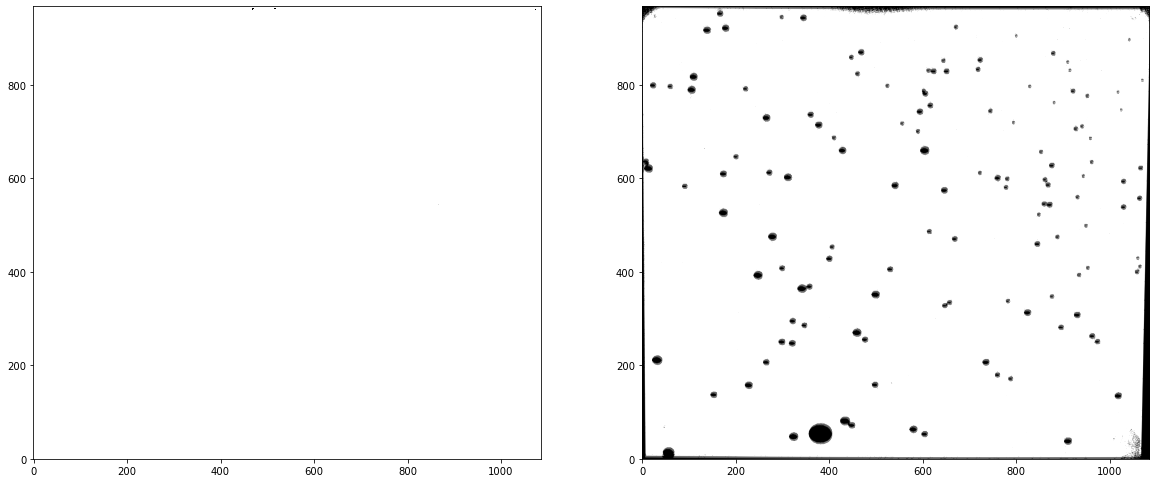

In [8]:
if camera=="UVO":
    sci = fits.getdata(filt+'_drc_sci.fits')
    wht = fits.getdata(filt+'_drc_wht.fits')
else:
    sci = fits.getdata(filt+'_drz_sci.fits')
    wht = fits.getdata(filt+'_drz_wht.fits')
print(camera,sci)

fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(sci, vmin=-0.05, vmax=0.4, cmap='Greys_r', origin='lower')
ax2.imshow(wht, vmin=0, vmax=1000, cmap='Greys_r', origin='lower')

In [13]:
testim=glob.glob("*"+kind+".fits")[0]
print(testim[:-5]+".orig.fits")
dq=fits.getdata(testim,3)
origdq=fits.getdata(testim[:-5]+".orig.fits",3)
fig = plt.figure(figsize=(20, 20))
#ax1 = fig.add_subplot(1, 2, 1)
#ax2 = fig.add_subplot(1, 2, 2)
ax2=fig.add_subplot(111)
#ax1.imshow(origdq, cmap='Greys_r', origin='lower')
ax2.imshow(dq-origdq, cmap='Greys_r', origin='lower',interpolation="nearest")

icbna6joq_flt.orig.fits


IndexError: list index out of range